# Practica Modulo Machine Learning -- Daniel Alvaro

En este notebook vamos a abordar la práctica del modulo de Machine Learning siguiendo los siguientes pasos.

1. Generación de nuevas características a partir de las existentes
2. Codificación de variables
3. Análisis exploratorio
4. Selección y evaluación del modelo
5. Comparativa de distintos algoritmos

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

## Datos de entrada

Cargamos los datos del fichero de airbnb reducido.
Este fichero contiene 14870 observaciones y 89 variables

In [2]:
full_airbnb = pd.read_csv('./data/airbnb-listings.csv',sep=';', decimal='.')

In [3]:
full_airbnb.shape
full_airbnb['Zipcode'].isna().sum()

506

Antes de llevar a cabo el split entre Trainintg y Test eliminamos las columnas que tenemos claro que no van a ser utiles para nuestro objetivo:
1. Las que contienen URLs: Listing Url: drop_url  
2. Los Ids y lo relativo al Scrape realizado: drop_id_scrape
3. Nombres y comentarios:drop_comments
4. Direcciones: Para simplificar el tratamiento del modelo y debido al ruido que continen las variables de direccion solo nos quedaremos con el zip code:drop_address
5. Informascion relativa al Hospedador: drop_host

In [4]:
drop_url = np.array(['Listing Url', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL',
                     'Host Thumbnail Url','Host Picture Url'])
full_airbnb.drop(drop_url, axis=1, inplace=True)

drop_id_scrape = np.array(['ID', 'Scrape ID', 'Last Scraped', 'Host ID', 'Calendar last Scraped'])
full_airbnb.drop(drop_id_scrape, axis=1, inplace=True)


drop_comments = np.array(['Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                     'Transit','Access', 'Interaction', 'House Rules', 'Host Name', 'Experiences Offered',
                         'Host About', 'Amenities', 'Features'])

full_airbnb.drop(drop_comments, axis=1, inplace=True)

drop_address = np.array(['Host Location', 'Host Neighbourhood', 'Street', 'Neighbourhood', 
    'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed','City', 'State', 'Market', 'Smart Location',
    'Country Code', 'Country', 'Latitude', 'Longitude', 'Jurisdiction Names', 'Geolocation'])

full_airbnb.drop(drop_address, axis=1, inplace=True)

drop_host = np.array(['Host Since', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 
    'Host Listings Count', 'Host Total Listings Count','Host Verifications', 'Calculated host listings count'])

full_airbnb.drop(drop_host, axis=1, inplace=True)



Por ultimo eliminamos varios campos sueltos por los siguientes motivos:
* Square Feet: Contiene 14182 observaciones null
* Weekly Price: Contiene 11190 observaciones null
* Monthly Price: Contiene 11219 obsevaciones null
* Has Availability: Contiene 12768 observaciones null
* First Review: No creemos que aporte informacion util para el calculo del precio
* Last Review: No creemos que aporte informacion util para el calculo del precio
* Calendar Updated: No creemos que aporte informacion util para el calculo del precio
* License: Contiene 14431 observaciones null
* Bed Type: Casi el 99% de las camas son del mismo tipo (Real Bed)



In [5]:
drop_varios = np.array(['Square Feet', 'Weekly Price', 'Monthly Price', 'Has Availability', 'First Review', 'Last Review',
                     'Calendar Updated','License', 'Bed Type'])

full_airbnb.drop(drop_varios, axis=1, inplace=True)


In [6]:
full_airbnb.shape

(14780, 28)

Tras la limpeza inicial nos hemos quedado con 28 caracteristicas.

Ahora, y antes de pasar al analisis exploratorio y la seleccion de caratresiticas procemos a la divsion del dataset de entrada en train y test. De moento y por si llevamos a cabo tratamiento de outliers no separaremos la variable objetivo del resto de caracteristicas.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_airbnb, test_size=0.2, shuffle=True, random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
# Guardamos
train.to_csv('./data/train.csv', sep=';', decimal='.', index=False)
test.to_csv('./data/test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 28)
Dimensiones del dataset de test: (2956, 28)


**Tengamos en cuenta que a partir de ahora todo el analisis exploratorio y selección de caracteristicas se hara sobre el dataset de entrenamiento.**

**Posteriormente todas transformaciones llevadas a cabo en dicho dataset se deberan implementar en el de Test.**

En primer lugar trataremos las tres variables categoricas que nos quedan (Property Type, Room Type y Cancellation Policy)

In [8]:
print(train['Property Type'].value_counts())
print(train['Room Type'].value_counts())
print(train['Cancellation Policy'].value_counts())


Apartment             9601
House                 1074
Condominium            288
Bed & Breakfast        275
Loft                   247
Other                  181
Dorm                    35
Guesthouse              32
Chalet                  19
Townhouse               15
Hostel                  14
Villa                   13
Serviced apartment       9
Boat                     3
Boutique hotel           3
Guest suite              3
Casa particular          3
Camper/RV                3
Earth House              2
Bungalow                 2
Timeshare                1
Tent                     1
Name: Property Type, dtype: int64
Entire home/apt    7184
Private room       4484
Shared room         156
Name: Room Type, dtype: int64
strict             4576
flexible           3777
moderate           3373
strict_new           28
super_strict_60      25
moderate_new         17
super_strict_30      16
flexible_new         12
Name: Cancellation Policy, dtype: int64


Vamos a dejar las categorias de Property Type en "Apartment", "House", "Condominium", "Bed & Breakfast" y "Loft", que representan mas del 95% del total y todas las demas las incluiremos en la categoría "Other"

In [9]:
array_to_replace = ['Dorm', 'Guesthouse', 'Chalet', 'Townhouse', 'Hostel', 'Villa', 'Serviced apartment', 'Casa particular',
                   'Boat', 'Camper/RV', 'Boutique hotel', 'Guest suite', 'Bungalow', 'Earth House', 'Tent', 'Timeshare']
train['Property Type'] = train['Property Type'].replace(array_to_replace, 'Other')
print(train['Property Type'].value_counts())

Apartment          9601
House              1074
Other               339
Condominium         288
Bed & Breakfast     275
Loft                247
Name: Property Type, dtype: int64


De la misma manera vamos a dejar las categorias de Cancellation Policy en "strict", "flexible" y "moderate", que representan mas del 96% del totak y todas las demas las incluiremos en la categoría "Other"

In [10]:
array_to_replace2 = ['strict_new', 'super_strict_60', 'moderate_new', 'super_strict_30', 'flexible_new']
train['Cancellation Policy'] = train['Cancellation Policy'].replace(array_to_replace2, 'Other')
print(train['Cancellation Policy'].value_counts())

strict      4576
flexible    3777
moderate    3373
Other         98
Name: Cancellation Policy, dtype: int64


## LabelEncoder
Una vez reducidas las categorias de las variables categoricas, las convertiremos en numericas mediante LabelEncoder

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train['Property Type'])
train['Property Type'] =  le.transform(train['Property Type'])

le.fit(train['Cancellation Policy'])
train['Cancellation Policy'] =  le.transform(train['Cancellation Policy'])

le.fit(train['Room Type'])
train['Room Type'] =  le.transform(train['Room Type'])

Antes de pasar a la correlacion de variables llevemos a cabo un análisis rapido de las caracteristicas que nos quedan

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Property Type,11824.0,0.571380,1.289511,0.00,0.00,0.0,0.00,5.00
Room Type,11824.0,0.405616,0.517205,0.00,0.00,0.0,1.00,2.00
Accommodates,11824.0,3.276641,2.106127,1.00,2.00,3.0,4.00,16.00
Bathrooms,11779.0,1.286442,0.667359,0.00,1.00,1.0,1.00,8.00
Bedrooms,11806.0,1.346773,0.909841,0.00,1.00,1.0,2.00,10.00
Beds,11789.0,2.051065,1.641454,1.00,1.00,2.0,2.00,16.00
Price,11810.0,73.702794,72.203846,9.00,34.00,55.0,87.00,999.00
Security Deposit,5035.0,190.150745,117.420048,0.00,100.00,150.0,200.00,990.00
Cleaning Fee,6967.0,32.152146,32.030358,0.00,15.00,25.0,40.00,662.00
Guests Included,11824.0,1.586181,1.182357,1.00,1.00,1.0,2.00,16.00


In [13]:
train['Availability 30'].value_counts()
train['Availability 30'].isna().sum()

0

## Correlacion de variables
Tengamos en cuenta que 

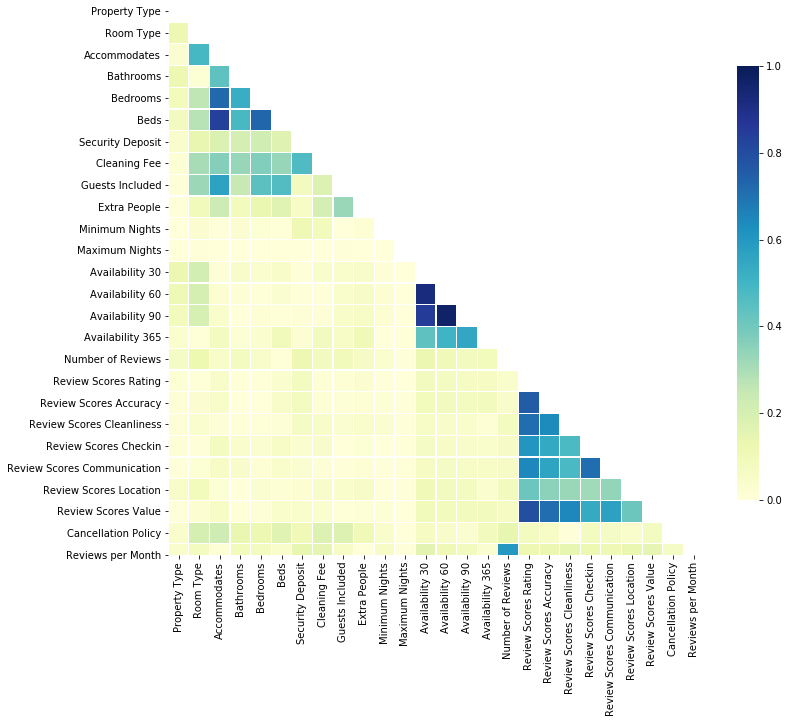

In [14]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(train.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Pintemos algunas variables

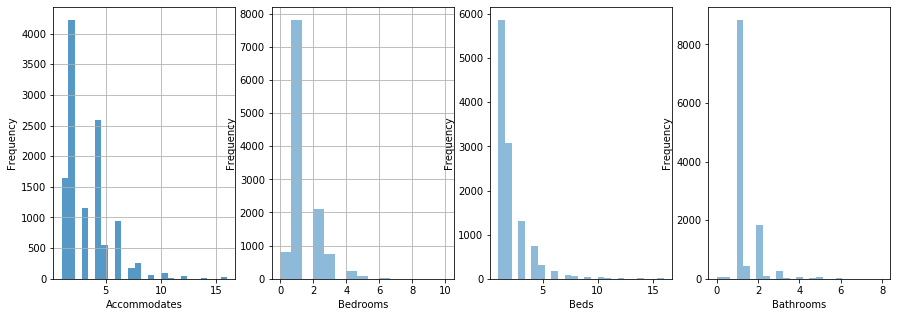

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
train['Accommodates'].plot.hist(alpha=0.75, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('Accommodates')

plt.subplot(1,4,2)
train['Bedrooms'].plot.hist(alpha=0.5, bins=15, grid = True)
plt.xlabel('Bedrooms')

plt.subplot(1,4,3)
train['Beds'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Beds')

plt.subplot(1,4,4)
train['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = False)
plt.xlabel('Bathrooms')

plt.show()

A la vista de la grafica de correlacion y siendo un poco generosos con las variables a eliminar para simplificar el modelo, podemos deducir lo siguiente:
1. **Accommodates** tiene una fuerte correlacion con Bedrooms, Beds y moderada con Guests Included
2. **Availability 30** tiene fuerte correlacion con Availability 60 Availability 90 y moderada con Availability 365
3. **Review Scores Rating** tiene una fuerte correlacion con Review Scores Accuracy, Review Scores Cleanliness, Review Scores Checkin, Review Scores Communication, Review Scores Value y moderada con Review Scores Location.
4. **Number of Reviews** tiene fuerte  correlacion con Reviews per Month

In [16]:
#Vamos a eliminar todas estas variables del dataset de entrenamiento
drop_corr = ['Bedrooms', 'Beds', 'Guests Included', 'Availability 60', 'Availability 90', 'Availability 365',
             'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication',
             'Review Scores Value', 'Review Scores Location', 'Reviews per Month']
train.drop(drop_corr, axis=1, inplace=True)
train.shape

(11824, 15)

## Separacion variable dependiente 
Separemos el dataset train entre la varible dependiente (y_train) y el resto de variables independientes (X_train)


In [17]:
y_train = train['Price']
X_train= train.drop(['Price'], axis=1)


Analicemos la variable ZipCode

In [18]:
print(len(X_train['Zipcode'].unique()))
print(X_train['Zipcode'].isna().sum())
X_train['Zipcode'].value_counts()

535
395


28012      1655
28004      1419
28005       977
28013       816
28014       512
           ... 
E8 3DQ        1
1130          1
11216         1
W12           1
NW8 8BD       1
Name: Zipcode, Length: 534, dtype: int64

Tenemos 11824 resgitros los cuales corresponden a 535 codigos postales distintos, sin embargo no todos esos codigos postales son validos, ademas tenemos 395 valores nan
Para poder trabajar con Zipcode y poder aplicarle metodos de filtrado vamos a asignarles a todos lo valores que no son numericos (lo que incluye los NaN) el valor 88888

In [19]:
#Debo pasar todos los valores de Zipcode a str (no se porque habia algunos que eran float) para poder aplicarle la condicion
# de isnumeric
X_train['Zipcode'] =  [str(i) for i in X_train['Zipcode']]
X_train['Zipcode'] = [s if s.isnumeric() else '88888' for s in X_train['Zipcode']]

#Por ultimo los paso todos a numeros
X_train['Zipcode'] =  [int(i) for i in X_train['Zipcode']]
X_train['Zipcode'].value_counts()

28012    1655
28004    1419
28005     977
28013     816
88888     562
         ... 
1012        1
11233       1
11225       1
10969       1
2049        1
Name: Zipcode, Length: 396, dtype: int64

El siguiente paso es aplicar los metodos de filtrados para regresion, pero esto solo se pueden aplicar sobre variables que no contienen valores NaN.
por tanto analicemos que variables tienen valores NaN y llevemos a cabo el proceso de imputacion, aprovechare para analizar algun posible outlier

Para hacerlo vamos a aplicar los siguientes comandos a todas las variables que quedan:
```
print(len(X_train['campo'].unique()))
print(X_train['campo'].isna().sum())
print(X_train['campo'].value_counts())

```

Haciendo esto vemos que los unicos campos que contienen NaNs son:
- Bathroom (45) Imputamos la media (1.3)
- Security Deposit (6798). Es mas de la mitad de los regitros por lo que lo eliminamos
- Cleaning Fee (4857). Imputamnos la media (32)
- Review Scores Rating (2651). Imputamos la mediana (77) ya que la media esta demasiado cerca de la mejor puntuacion.

In [21]:
X_train.drop('Security Deposit', axis=1, inplace=True)

In [26]:
X_train['Bathrooms'] = train['Bathrooms'].fillna(1.3)
X_train['Cleaning Fee'] = train['Cleaning Fee'].fillna(32)
X_train['Review Scores Rating'] = train['Review Scores Rating'].fillna(77)

## Variable objetivo
Por ultimo analizamos la variable objetivo

In [28]:
y_train.describe()

count    11810.000000
mean        73.702794
std         72.203846
min          9.000000
25%         34.000000
50%         55.000000
75%         87.000000
max        999.000000
Name: Price, dtype: float64

In [29]:
print(len(y_train.unique()))
print(y_train.isna().sum())
print(y_train.value_counts())
print(np.mean(y_train)) 

348
14
50.0     513
60.0     441
30.0     437
25.0     433
35.0     381
        ... 
356.0      1
252.0      1
154.0      1
222.0      1
434.0      1
Name: Price, Length: 347, dtype: int64
73.70279424216766


In [30]:
y_train = y_train.fillna(74)

## Filtrado para regresion
Con las 13 variables que me quedan aplico los metodos de fitrado **f_regresion** y **mutual_info_regresion**

In [45]:
from sklearn.feature_selection import f_regression, mutual_info_regression
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

Mostremos esta informacion en forma de grafica

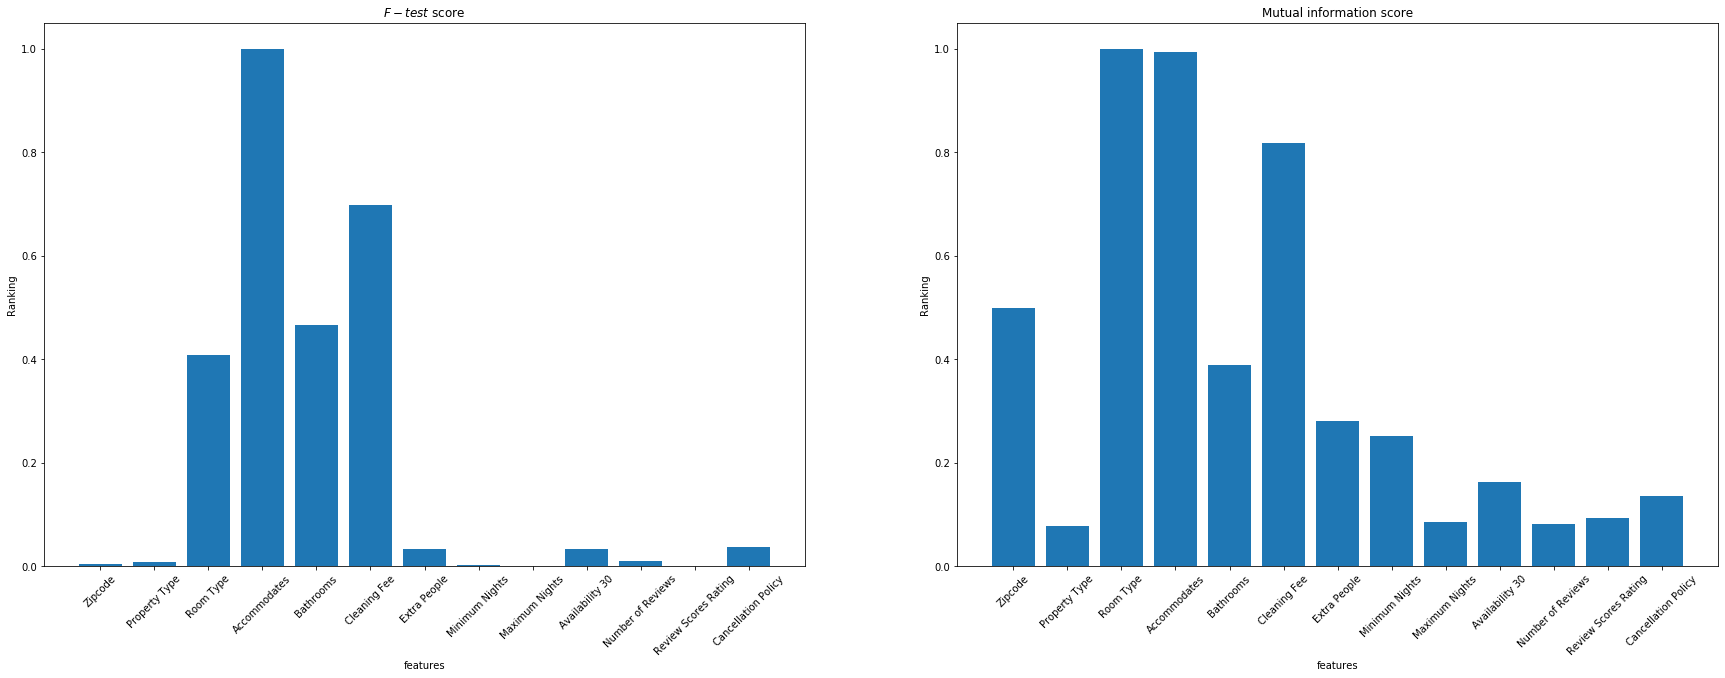

In [82]:
featureNames = list(X_train.columns)

plt.figure(figsize=(30, 10))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi,  align="center")
plt.xticks(range(X_train.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

A la vista de las graficas y de los valores de f_test y mi las variables que mas estan impactando en la variable objetivo son:
- Zipcode
- Room Type
- Accommodates
- Bathrooms
- Cleaning Fee

Por tanto seran estas las variables que usare para testear mis modelos, elimando el resto del dataset de training

In [84]:
drop_filtrado = ['Property Type', 'Extra People', 'Minimum Nights', 'Maximum Nights', 'Availability 30', 'Number of Reviews',
                'Review Scores Rating', 'Cancellation Policy']
X_train.drop(drop_filtrado, axis=1, inplace=True)

## StandarScaler
Por ultimo llevamos a cabo el escalado (Normalizacion)


In [86]:
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

**Y hasta aqui el analisis exploratorio y la limpieza del dataset, empezamos con las pruebas de los modelos**

## Prueba de Modelos